<a href="https://colab.research.google.com/github/uladzimirkapeika/1c_sales/blob/master/25gb_1c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [1]:
!pip install neptune-client
!pip install neptune-client neptune-contrib[monitoring]

     |████████████████████████████████| 92kB 4.9MB/s 
     |████████████████████████████████| 829kB 28.8MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 204kB 51.1MB/s 
     |████████████████████████████████| 163kB 54.8MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 143kB 59.1MB/s 
     |████████████████████████████████| 133kB 20.8MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.4.119-py2.py3-none-any.whl size=150019 sha256=715bea79541c69cd59fa041cad63aa2c342fbd5eb4a574b96f4813fe1e0f6b2a
  Stored in directory: /root/.cache/pip/wheels/84/5c/c1/a81e80761b94b4467fd3fda1fd3109463702f6247fc422eb33
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=037e07b9c12a84e8a685013dc1bd3dc7c125654d040aad8d4d1881c87df49aac
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
import neptune
from neptunecontrib.monitoring.lightgbm import neptune_monitor
import joblib


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Read data

In [3]:
test = pd.read_csv('/content/drive/My Drive/1C/test.csv')
sales = pd.read_csv('/content/drive/My Drive/1C/sales_train.csv')
shops = pd.read_csv('/content/drive/My Drive/1C//shops.csv')
items = pd.read_csv('/content/drive/My Drive/1C/items.csv')
item_cats = pd.read_csv('/content/drive/My Drive/1C/item_categories.csv')

In [4]:
#test_shop_ids = test['shop_id'].unique()
#test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
#sales = sales[sales['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
#sales = sales[sales['item_id'].isin(test_item_ids)]

In [5]:
sales[sales['item_price'] <= 1]['item_price'] = sales['item_price'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Shops

In [6]:
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0].lower())
shops.loc[shops.city == '!якутск', 'city'] = 'якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])

coords = dict()
coords['якутск'] = (62.028098, 129.732555, 4)
coords['адыгея'] = (44.609764, 40.100516, 3)
coords['балашиха'] = (55.8094500, 37.9580600, 1)
coords['волжский'] = (53.4305800, 50.1190000, 3)
coords['вологда'] = (59.2239000, 39.8839800, 2)
coords['воронеж'] = (51.6720400, 39.1843000, 3)
coords['выездная'] = (0, 0, 0)
coords['жуковский'] = (55.5952800, 38.1202800, 1)
coords['интернет-магазин'] = (0, 0, 0)
coords['казань'] = (55.7887400, 49.1221400, 4)
coords['калуга'] = (54.5293000, 36.2754200, 4)
coords['коломна'] = (55.0794400, 38.7783300, 4)
coords['красноярск'] = (56.0183900, 92.8671700, 4)
coords['курск'] = (51.7373300, 36.1873500, 3)
coords['москва'] = (55.7522200, 37.6155600, 1)
coords['мытищи'] = (55.9116300, 37.7307600, 1)
coords['н.новгород'] = (56.3286700, 44.0020500, 4)
coords['новосибирск'] = (55.0415000, 82.9346000, 4)
coords['омск'] = (54.9924400, 73.3685900, 4)
coords['ростовнадону'] = (47.2313500, 39.7232800, 3)
coords['спб'] = (59.9386300, 30.3141300, 2)
coords['самара'] = (53.2000700, 50.1500000, 4)
coords['сергиев'] = (56.3000000, 38.1333300, 4)
coords['сургут'] = (61.2500000, 73.4166700, 4)
coords['томск'] = (56.4977100, 84.9743700, 4)
coords['тюмень'] = (57.1522200, 65.5272200, 4)
coords['уфа'] = (54.7430600, 55.9677900, 4)
coords['химки'] = (55.8970400, 37.4296900, 1)
coords['цифровой'] = (0, 0, 0)
coords['чехов'] = (55.1477000, 37.4772800, 4)
coords['ярославль'] = (57.6298700, 39.8736800, 2) 

shops['city_coord_1'] = shops['city'].apply(lambda x: coords[x][0])
shops['city_coord_2'] = shops['city'].apply(lambda x: coords[x][1])
shops['country_part'] = shops['city'].apply(lambda x: coords[x][2])

#shops = shops[['shop_id', 'city_code', 'city_coord_1', 'city_coord_2', 'country_part']]

In [7]:
#!pip install python-levenshtein

In [8]:
#import Levenshtein#
#
#similar_items = []
#items_names = list(items['item_name'].unique())
#for ind2, name2 in enumerate(items_names):
#  if not ind2%1000:
#        print(ind2,' ',len(similar_items))
#  for ind1, name1 in enumerate(items_names[ind2:]):
#    nltk_dist = Levenshtein.distance(name1, name2)
#    if name1!=name2 and (abs(nltk_dist) <=2 or name1 in name2 or name2 in name1) and abs(len(name1) - len(name2)) <= 3:
#      similar_items.append(name2)

In [9]:
#sorted_sim = sorted(set(similar_items))


In [10]:
#group_ind = 0
#ind = 0
#group_list = [[]] 
#for i in range(len(sorted_sim)-1):
#  while True:
#    if ind > len(sorted_sim)-2:
#        break
#    name1 = sorted_sim[ind]
#    name2 = sorted_sim[ind+1]
#    nltk_dist = Levenshtein.distance(name1, name2)
#    if (abs(nltk_dist) <=10 or name1 in name2 or name2 in name1) and abs(len(name1) - len(name2)) <= 10:
#        group_list[group_ind].append(name1)
#       ind = ind+1#
#    else:
#      break
#  ind = ind+1        
#  group_ind = group_ind + 1      
#  group_list.append([])



In [11]:
def map_items(x):
  if x not in sim_items:
    return x
  else:
      for group in group_list:
        if x in group:
          return x[0]    

In [12]:
items = pd.merge(items, item_cats, on='item_category_id')
items['item_category'] = items['item_category_name'].apply(lambda x: x.split('-')[0])
print(items['item_category'].unique())
map_dict = {
            #'Игры PC ': 'Игры ',
            #'Карты оплаты (Кино, Музыка, Игры)':'Карты оплаты ',
            #'Игры MAC ':'Игры ',
            'Чистые носители (штучные)': 'Чистые носители',
            'Чистые носители (шпиль)' : 'Чистые носители',
            'PC ': 'Аксессуары',
            #'Игры Android ': 'Игры ',
            'Служебные': 'Служебные '
            }
items['item_category'] = items['item_category'].apply(lambda x: map_dict[x] if x in map_dict.keys() else x)

items['item_category_common'] = LabelEncoder().fit_transform(items['item_category'])
items['item_category_code'] = LabelEncoder().fit_transform(items['item_category_name'])
#items['item_similar_name'] =  items['item_name'].apply(map_items)
#items['item_similar_code'] =  LabelEncoder().fit_transform(items['item_similar_name'])
#items['item_bool_sim'] = items['item_name'].apply(lambda x: 1 if x in sorted_sim else 0)
items = items[['item_id', 'item_category_common', 'item_category_code']]

['Кино ' 'Программы ' 'Музыка ' 'Игры ' 'Игры PC ' 'Книги ' 'Подарки '
 'Карты оплаты (Кино, Музыка, Игры)' 'Аксессуары ' 'Игры MAC '
 'Игры Android ' 'Игровые консоли ' 'PC ' 'Карты оплаты ' 'Билеты (Цифра)'
 'Служебные ' 'Доставка товара' 'Чистые носители (штучные)'
 'Чистые носители (шпиль)' 'Служебные' 'Элементы питания']


# Create dataset

In [13]:
train = sales[sales.item_price < 100000]
train = train[sales.item_cnt_day < 1001]

train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

train.loc[train.shop_id == 40, 'shop_id'] = 39
test.loc[test.shop_id == 40, 'shop_id'] = 39

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [14]:
#train.loc[train.item_id == 13011, 'item_id'] = 13012
#test.loc[test.item_id == 13011, 'item_id'] = 13012

#train.loc[train.item_id == 12, 'item_id'] = 14690
#test.loc[test.item_id == 12, 'item_id'] = 14690

In [15]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

df = [] 
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

df = pd.DataFrame(np.vstack(df), columns = index_cols,dtype=np.int32)
df.head(5)

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [16]:
#Add month sales
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

df = pd.merge(df, group, on=index_cols, how='left')
df['item_cnt_month'] = (df['item_cnt_month']
                                .clip(0, 20)
                                .fillna(0)
                                .astype(np.float16))
df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0


In [17]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
df = pd.concat([df, test], ignore_index=True, sort=False, keys=index_cols)
df.fillna(0, inplace=True)
df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,ID
0,59,22154,0,1.0,0.0
1,59,2552,0,0.0,0.0
2,59,2554,0,0.0,0.0
3,59,2555,0,0.0,0.0
4,59,2564,0,0.0,0.0


In [18]:
# Add items and shops features
df = pd.merge(df, items, on=['item_id'], how='left')
df = pd.merge(df, shops, on=['shop_id'], how='left')

In [19]:
#Calculate intersection features

df1 = df.copy()
first_shop_item_block = df1.groupby(['shop_id', 'item_id'])['date_block_num'].min().reset_index()
first_shop_item_block['shop_item_first_interaction'] = 1

first_item_block = df1.groupby(['item_id'])['date_block_num'].min().reset_index()
first_item_block['item_first_interaction'] = 1

first_shop_item_buy_block = df1[df1['date_block_num'] > 0].groupby(['shop_id', 'item_id'])['date_block_num'].min().reset_index()
first_shop_item_buy_block['first_date_block_num'] = first_shop_item_buy_block['date_block_num']




In [20]:
df = pd.merge(df, first_shop_item_block[['item_id', 'shop_id', 'date_block_num', 'shop_item_first_interaction']], on=['item_id', 'shop_id', 'date_block_num'], how='left')
df = pd.merge(df, first_item_block[['item_id', 'date_block_num', 'item_first_interaction']], on=['item_id', 'date_block_num'], how='left')
df = pd.merge(df, first_shop_item_buy_block[['item_id', 'shop_id', 'first_date_block_num']], on=['item_id', 'shop_id'], how='left')

df['first_date_block_num'].fillna(100, inplace=True)
df['shop_item_sold_before'] = (df['first_date_block_num'] < df['date_block_num']).astype('int8')
df.drop(['first_date_block_num'], axis=1, inplace=True)

df['item_first_interaction'].fillna(0, inplace=True)
df['shop_item_first_interaction'].fillna(0, inplace=True)
df['shop_item_sold_before'].fillna(0, inplace=True)

df['shop_item_first_interaction'] = df['shop_item_first_interaction'].astype('int8')  
df['item_first_interaction'] = df['item_first_interaction'].astype('int8')  
df['shop_item_sold_before'] = df['shop_item_sold_before'].astype('int8') 


In [21]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)] = df[col+'_lag_'+str(i)].astype('float32')
    return df

df = lag_feature(df, [1, 2, 3], 'item_cnt_month')
#df.fillna(0, inplace=True) best validation quality bad kaggle

In [22]:
def lag_feature_adv(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)+'_adv']
        shifted['date_block_num'] += i
        shifted['item_id'] -= 1
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)+'_adv'] = df[col+'_lag_'+str(i)+'_adv'].astype('float32')
    return df

df = lag_feature_adv(df, [1, 2, 3], 'item_cnt_month')

In [23]:
train = pd.merge(train, shops, on=['shop_id'], how='left')
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,city,city_code,city_coord_1,city_coord_2,country_part
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",москва,13,55.75222,37.61556,1
2,05.01.2013,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",москва,13,55.75222,37.61556,1
3,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",москва,13,55.75222,37.61556,1
4,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",москва,13,55.75222,37.61556,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2935842,10.10.2015,33,25,7409,299.00,1.0,"Москва ТРК ""Атриум""",москва,13,55.75222,37.61556,1
2935843,09.10.2015,33,25,7460,299.00,1.0,"Москва ТРК ""Атриум""",москва,13,55.75222,37.61556,1
2935844,14.10.2015,33,25,7459,349.00,1.0,"Москва ТРК ""Атриум""",москва,13,55.75222,37.61556,1
2935845,22.10.2015,33,25,7440,299.00,1.0,"Москва ТРК ""Атриум""",москва,13,55.75222,37.61556,1


In [24]:
#avg shop/item price
index_cols = ['shop_id', 'item_id', 'date_block_num']
group = train.groupby(index_cols)['item_price'].mean().reset_index().rename(columns={"item_price": "avg_shop_price"}, errors="raise")
df = pd.merge(df, group, on=index_cols, how='left')

df['avg_shop_price'] = (df['avg_shop_price']
                                .fillna(0)
                                .astype(np.float16))

#avg shop/item price
index_cols = ['item_id', 'date_block_num']
group = train.groupby(['date_block_num','item_id'])['item_price'].mean().reset_index().rename(columns={"item_price": "avg_item_price"}, errors="raise")


df = pd.merge(df, group, on=index_cols, how='left')
df['avg_item_price'] = (df['avg_item_price']
                                .fillna(0)
                                .astype(np.float16))
df['item_shop_price_avg'] = (df['avg_shop_price'] - df['avg_item_price']) / df['avg_item_price']
df = lag_feature(df, [1, 2, 3], 'item_shop_price_avg')
df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,ID,item_category_common,item_category_code,shop_name,city,city_code,city_coord_1,city_coord_2,country_part,shop_item_first_interaction,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_1_adv,item_cnt_month_lag_2_adv,item_cnt_month_lag_3_adv,avg_shop_price,avg_item_price,item_shop_price_avg,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3
0,59,22154,0,1.0,0.0,11,37,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,999.0,999.0,0.0,NaN,NaN,NaN
1,59,2552,0,0.0,0.0,13,58,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,899.0,-1.0,NaN,NaN,NaN
2,59,2554,0,0.0,0.0,13,58,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1709.0,-1.0,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,13,56,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1099.0,-1.0,NaN,NaN,NaN
4,59,2564,0,0.0,0.0,13,59,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,327.5,-1.0,NaN,NaN,NaN


In [25]:
group = train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

df = df.merge(group, on = ["item_id"], how = "left" )

group = train.groupby( ["date_block_num","item_id"] ).agg({"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

df = df.merge(group, on = ["date_block_num","item_id"], how = "left")

df['delta_price'] = (df['date_item_avg_item_price'] - df['item_avg_item_price']) / df['item_avg_item_price'] 


In [26]:
df['delta_price'] = (df['delta_price']
                                .fillna(0))

#df = lag_feature(df, [1, 2, 3], 'delta_price')
df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,ID,item_category_common,item_category_code,shop_name,city,city_code,city_coord_1,city_coord_2,country_part,shop_item_first_interaction,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_1_adv,item_cnt_month_lag_2_adv,item_cnt_month_lag_3_adv,avg_shop_price,avg_item_price,item_shop_price_avg,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,item_avg_item_price,date_item_avg_item_price,delta_price
0,59,22154,0,1.0,0.0,11,37,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,999.0,999.0,0.0,NaN,NaN,NaN,702.932203,999.00,0.421190
1,59,2552,0,0.0,0.0,13,58,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,899.0,-1.0,NaN,NaN,NaN,937.888889,899.00,-0.041464
2,59,2554,0,0.0,0.0,13,58,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1709.0,-1.0,NaN,NaN,NaN,1709.050000,1709.05,0.000000
3,59,2555,0,0.0,0.0,13,56,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1099.0,-1.0,NaN,NaN,NaN,1123.101786,1098.85,-0.021594
4,59,2564,0,0.0,0.0,13,59,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,327.5,-1.0,NaN,NaN,NaN,340.152174,327.60,-0.036902


In [27]:
#add date features

import calendar
from datetime import datetime

def count_days(date_block_num):
    year = 2013 + date_block_num // 12
    month = 1 + date_block_num % 12
    weeknd_count = len([1 for i in calendar.monthcalendar(year, month) if i[6] != 0])
    days_in_month = calendar.monthrange(year, month)[1]
    return weeknd_count, days_in_month, month

map_dict = {i: count_days(i) for i in range(35)}

df['weeknd_count'] = df['date_block_num'].apply(lambda x: map_dict[x][0])
df['days_in_month'] = df['date_block_num'].apply(lambda x: map_dict[x][1])
df['month'] = df['date_block_num'].apply(lambda x: map_dict[x][2])

In [28]:
#df = pd.merge(df, sales, on=['date_block_num','shop_id','item_id'], how='left')
#sales['date'] = pd.to_datetime(sales['date'])
#sales['month'] = sales['date'].dt.month

#columns=['month']
#for col in columns:
#    df[col+'_sin']=np.sin((2*np.pi*df[col])/max(df[col]))
#    df[col+'_cos']=np.cos((2*np.pi*df[col])/max(df[col]))

#sales['mean_month_price'] = sales['group_by']
#price_mean_shop = sales.groupby(['date_block_num','shop_id','item_id'])['item_price'].mean().reset_index().rename(columns={"item_price": "price_mean_shop"}, errors="raise")
#price_mean_item = sales.groupby(['date_block_num','item_id'])['item_price'].mean().reset_index().rename(columns={"item_price": "price_mean_item"}, errors="raise")
#sales = pd.merge(sales, price_mean_shop, on=['date_block_num','shop_id','item_id'], how='left')
#sales = pd.merge(sales, price_mean_item, on=['date_block_num','item_id'], how='left')
#sales['month_mean_price'] = 
#price_mean
#sales['mean_month_price'] = sales['mean_month_price']
#grid['item_target_enc'] = grid['item_id'].map(item_id_target_mean)
#grid['item_target_enc'].fillna(0, inplace=True)

In [29]:
item_id_target_mean = df.groupby(['date_block_num','item_id'])['item_cnt_month'].mean().reset_index().rename(columns={"item_cnt_month": "item_target_enc"}, errors="raise")
df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id'], how='left')

df['item_target_enc'] = (df['item_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'item_target_enc')
df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,ID,item_category_common,item_category_code,shop_name,city,city_code,city_coord_1,city_coord_2,country_part,shop_item_first_interaction,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_1_adv,item_cnt_month_lag_2_adv,item_cnt_month_lag_3_adv,avg_shop_price,avg_item_price,item_shop_price_avg,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,item_avg_item_price,date_item_avg_item_price,delta_price,weeknd_count,days_in_month,month,item_target_enc,item_target_enc_lag_1,item_target_enc_lag_2,item_target_enc_lag_3
0,59,22154,0,1.0,0.0,11,37,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,999.0,999.0,0.0,NaN,NaN,NaN,702.932203,999.00,0.421190,4,31,1,0.399902,NaN,NaN,NaN
1,59,2552,0,0.0,0.0,13,58,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,899.0,-1.0,NaN,NaN,NaN,937.888889,899.00,-0.041464,4,31,1,0.000000,NaN,NaN,NaN
2,59,2554,0,0.0,0.0,13,58,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1709.0,-1.0,NaN,NaN,NaN,1709.050000,1709.05,0.000000,4,31,1,0.022217,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,13,56,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1099.0,-1.0,NaN,NaN,NaN,1123.101786,1098.85,-0.021594,4,31,1,0.044434,NaN,NaN,NaN
4,59,2564,0,0.0,0.0,13,59,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,327.5,-1.0,NaN,NaN,NaN,340.152174,327.60,-0.036902,4,31,1,0.111084,NaN,NaN,NaN


In [30]:
item_id_target_mean = df.groupby(['date_block_num','item_id'])['item_cnt_month'].mean().reset_index().rename(columns={"item_cnt_month": "item_target_enc"}, errors="raise")
item_id_target_mean

,date_block_num,item_id,item_target_enc
0,0,19,0.022217
1,0,27,0.155518
2,0,28,0.177734
3,0,29,0.088867
4,0,32,5.378906
...,...,...,...
239006,34,22162,0.000000
239007,34,22163,0.000000
239008,34,22164,0.000000
239009,34,22166,0.000000


In [31]:
item_id_target_mean = df.groupby(['date_block_num','item_id', 'city_code'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_loc_target_enc"}, errors="raise")
df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id', 'city_code'], how='left')

df['item_loc_target_enc'] = (df['item_loc_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'item_loc_target_enc')
df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,ID,item_category_common,item_category_code,shop_name,city,city_code,city_coord_1,city_coord_2,country_part,shop_item_first_interaction,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_1_adv,item_cnt_month_lag_2_adv,item_cnt_month_lag_3_adv,avg_shop_price,avg_item_price,item_shop_price_avg,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,item_avg_item_price,date_item_avg_item_price,delta_price,weeknd_count,days_in_month,month,item_target_enc,item_target_enc_lag_1,item_target_enc_lag_2,item_target_enc_lag_3,item_loc_target_enc,item_loc_target_enc_lag_1,item_loc_target_enc_lag_2,item_loc_target_enc_lag_3
0,59,22154,0,1.0,0.0,11,37,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,999.0,999.0,0.0,NaN,NaN,NaN,702.932203,999.00,0.421190,4,31,1,0.399902,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1,59,2552,0,0.0,0.0,13,58,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,899.0,-1.0,NaN,NaN,NaN,937.888889,899.00,-0.041464,4,31,1,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,59,2554,0,0.0,0.0,13,58,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1709.0,-1.0,NaN,NaN,NaN,1709.050000,1709.05,0.000000,4,31,1,0.022217,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,13,56,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1099.0,-1.0,NaN,NaN,NaN,1123.101786,1098.85,-0.021594,4,31,1,0.044434,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,59,2564,0,0.0,0.0,13,59,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,327.5,-1.0,NaN,NaN,NaN,340.152174,327.60,-0.036902,4,31,1,0.111084,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [32]:
item_id_target_mean = df.groupby(['date_block_num','item_id', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_shop_target_enc"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id', 'shop_id'], how='left')

df['item_shop_target_enc'] = (df['item_shop_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'item_shop_target_enc')
df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,ID,item_category_common,item_category_code,shop_name,city,city_code,city_coord_1,city_coord_2,country_part,shop_item_first_interaction,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_1_adv,item_cnt_month_lag_2_adv,item_cnt_month_lag_3_adv,avg_shop_price,avg_item_price,item_shop_price_avg,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,item_avg_item_price,date_item_avg_item_price,delta_price,weeknd_count,days_in_month,month,item_target_enc,item_target_enc_lag_1,item_target_enc_lag_2,item_target_enc_lag_3,item_loc_target_enc,item_loc_target_enc_lag_1,item_loc_target_enc_lag_2,item_loc_target_enc_lag_3,item_shop_target_enc,item_shop_target_enc_lag_1,item_shop_target_enc_lag_2,item_shop_target_enc_lag_3
0,59,22154,0,1.0,0.0,11,37,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,999.0,999.0,0.0,NaN,NaN,NaN,702.932203,999.00,0.421190,4,31,1,0.399902,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1,59,2552,0,0.0,0.0,13,58,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,899.0,-1.0,NaN,NaN,NaN,937.888889,899.00,-0.041464,4,31,1,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,59,2554,0,0.0,0.0,13,58,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1709.0,-1.0,NaN,NaN,NaN,1709.050000,1709.05,0.000000,4,31,1,0.022217,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,13,56,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1099.0,-1.0,NaN,NaN,NaN,1123.101786,1098.85,-0.021594,4,31,1,0.044434,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,59,2564,0,0.0,0.0,13,59,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,327.5,-1.0,NaN,NaN,NaN,340.152174,327.60,-0.036902,4,31,1,0.111084,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [33]:
item_id_target_mean = df.groupby(['date_block_num','item_id', 'item_category_code'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_cat_target_enc"}, errors="raise")
df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id', 'item_category_code'], how='left')

df['item_cat_target_enc'] = (df['item_cat_target_enc']
                                .fillna(0)
                                .astype(np.float16))

#df = lag_feature(df, [1, 2, 3], 'item_cat_target_enc')
df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,ID,item_category_common,item_category_code,shop_name,city,city_code,city_coord_1,city_coord_2,country_part,shop_item_first_interaction,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_1_adv,item_cnt_month_lag_2_adv,item_cnt_month_lag_3_adv,avg_shop_price,avg_item_price,item_shop_price_avg,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,item_avg_item_price,date_item_avg_item_price,delta_price,weeknd_count,days_in_month,month,item_target_enc,item_target_enc_lag_1,item_target_enc_lag_2,item_target_enc_lag_3,item_loc_target_enc,item_loc_target_enc_lag_1,item_loc_target_enc_lag_2,item_loc_target_enc_lag_3,item_shop_target_enc,item_shop_target_enc_lag_1,item_shop_target_enc_lag_2,item_shop_target_enc_lag_3,item_cat_target_enc
0,59,22154,0,1.0,0.0,11,37,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,999.0,999.0,0.0,NaN,NaN,NaN,702.932203,999.00,0.421190,4,31,1,0.399902,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.399902
1,59,2552,0,0.0,0.0,13,58,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,899.0,-1.0,NaN,NaN,NaN,937.888889,899.00,-0.041464,4,31,1,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000
2,59,2554,0,0.0,0.0,13,58,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1709.0,-1.0,NaN,NaN,NaN,1709.050000,1709.05,0.000000,4,31,1,0.022217,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.022217
3,59,2555,0,0.0,0.0,13,56,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1099.0,-1.0,NaN,NaN,NaN,1123.101786,1098.85,-0.021594,4,31,1,0.044434,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.044434
4,59,2564,0,0.0,0.0,13,59,"Ярославль ТЦ ""Альтаир""",ярославль,30,57.62987,39.87368,2,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,327.5,-1.0,NaN,NaN,NaN,340.152174,327.60,-0.036902,4,31,1,0.111084,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.111084


In [34]:
#df.fillna(0, inplace=True)
df['delta_count_month_1'] = (df['item_cnt_month_lag_1'] - (df['item_cnt_month_lag_2'])) / (df['item_cnt_month_lag_2'])
df['delta_count_month_2'] = (df['item_cnt_month_lag_2'] - (df['item_cnt_month_lag_3'])) / (df['item_cnt_month_lag_3'])

In [35]:
df[df['delta_count_month_1'] == np.inf]['delta_count_month_1'] = -1
df[df['delta_count_month_2'] == np.inf]['delta_count_month_2'] = -1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
df.fillna(0, inplace=True)
df = df[(df['date_block_num'] > 2)]
df.head()

,shop_id,item_id,date_block_num,item_cnt_month,ID,item_category_common,item_category_code,shop_name,city,city_code,city_coord_1,city_coord_2,country_part,shop_item_first_interaction,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_1_adv,item_cnt_month_lag_2_adv,item_cnt_month_lag_3_adv,avg_shop_price,avg_item_price,item_shop_price_avg,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,item_avg_item_price,date_item_avg_item_price,delta_price,weeknd_count,days_in_month,month,item_target_enc,item_target_enc_lag_1,item_target_enc_lag_2,item_target_enc_lag_3,item_loc_target_enc,item_loc_target_enc_lag_1,item_loc_target_enc_lag_2,item_loc_target_enc_lag_3,item_shop_target_enc,item_shop_target_enc_lag_1,item_shop_target_enc_lag_2,item_shop_target_enc_lag_3,item_cat_target_enc,delta_count_month_1,delta_count_month_2
1122795,25,8092,3,3.0,0.0,11,40,"Москва ТРК ""Атриум""",москва,13,55.75222,37.61556,1,0,0,1,1.0,0.0,4.0,7.0,5.0,13.0,149.0,146.125,0.019669,0.019669,-1.000000,0.047455,145.754233,146.178571,0.002911,4,30,4,0.608887,0.586914,0.630371,1.444336,0.833496,0.666504,0.666504,2.000000,3.0,1.0,0.0,4.0,0.608887,inf,-1.000000
1122796,25,7850,3,3.0,0.0,8,30,"Москва ТРК ""Атриум""",москва,13,55.75222,37.61556,1,0,0,1,5.0,1.0,6.0,0.0,0.0,0.0,199.0,199.000,0.000000,0.014656,0.025116,0.023132,196.991600,199.000000,0.010195,4,30,4,1.521484,1.869141,1.456055,3.089844,1.916992,2.916016,2.083984,2.916016,3.0,5.0,1.0,6.0,1.521484,4.0,-0.833333
1122797,25,8051,3,3.0,0.0,14,66,"Москва ТРК ""Атриум""",москва,13,55.75222,37.61556,1,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,30.0,30.000,0.000000,-1.000000,-1.000000,-1.000000,27.083333,30.000000,0.107692,4,30,4,0.108704,0.043488,0.130493,0.133301,0.250000,0.000000,0.333252,0.333252,3.0,0.0,0.0,0.0,0.108704,0.0,0.000000
1122798,25,8088,3,1.0,0.0,13,55,"Москва ТРК ""Атриум""",москва,13,55.75222,37.61556,1,0,0,1,1.0,1.0,0.0,0.0,1.0,0.0,199.0,199.000,0.000000,0.000000,0.283936,-1.000000,186.380952,199.000000,0.067706,4,30,4,0.086975,0.130493,0.043488,0.066650,0.083313,0.166626,0.083313,0.000000,1.0,1.0,1.0,0.0,0.086975,0.0,inf
1122799,25,8089,3,1.0,0.0,13,55,"Москва ТРК ""Атриум""",москва,13,55.75222,37.61556,1,0,0,1,0.0,1.0,0.0,2.0,0.0,3.0,199.0,190.500,0.044617,-1.000000,0.038483,-1.000000,196.164532,190.523810,-0.028755,4,30,4,0.456543,0.478271,0.260986,0.177734,0.333252,0.666504,0.250000,0.083313,1.0,0.0,1.0,0.0,0.456543,-1.0,inf


Feature engineering

In [37]:
df.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'ID',
       'item_category_common', 'item_category_code', 'shop_name', 'city',
       'city_code', 'city_coord_1', 'city_coord_2', 'country_part',
       'shop_item_first_interaction', 'item_first_interaction',
       'shop_item_sold_before', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'item_cnt_month_lag_1_adv',
       'item_cnt_month_lag_2_adv', 'item_cnt_month_lag_3_adv',
       'avg_shop_price', 'avg_item_price', 'item_shop_price_avg',
       'item_shop_price_avg_lag_1', 'item_shop_price_avg_lag_2',
       'item_shop_price_avg_lag_3', 'item_avg_item_price',
       'date_item_avg_item_price', 'delta_price', 'weeknd_count',
       'days_in_month', 'month', 'item_target_enc', 'item_target_enc_lag_1',
       'item_target_enc_lag_2', 'item_target_enc_lag_3', 'item_loc_target_enc',
       'item_loc_target_enc_lag_1', 'item_loc_target_enc_lag_2',
       'item_loc_target_enc_lag_3', 'item_s

In [38]:
df.drop(['ID', 
         'avg_shop_price', 
         'avg_item_price', 
         'item_shop_price_avg', 
         'item_avg_item_price', 
         'delta_price_lag', 
         'item_target_enc',
         'item_loc_target_enc',
         'item_shop_target_enc',
         'date_item_avg_item_price',
         'delta_price',
         'item_cat_target_enc',
         'shop_name',
         'city'
         ], axis=1, inplace=True, errors='ignore')

In [39]:
df['item_cnt_month_lag_1_adv'].fillna(0)
df['item_cnt_month_lag_1_adv'].fillna(0)
df['item_cnt_month_lag_1_adv'].fillna(0)

1122795     7.0
1122796     0.0
1122797     0.0
1122798     0.0
1122799     2.0
           ... 
11056272    0.0
11056273    0.0
11056274    0.0
11056275    0.0
11056276    0.0
Name: item_cnt_month_lag_1_adv, Length: 9933482, dtype: float32

In [40]:
#df['shop_item_sold_before'] = df.apply(lambda x: -1 if x['item_first_interaction'] == 1 else x['shop_item_sold_before'], axis=1)


In [41]:
df['item_cnt_month'] = df['item_cnt_month'].clip(0, 20)

In [42]:
X_train = df[df.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = df[df.date_block_num < 33]['item_cnt_month']
X_valid = df[df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = df[df.date_block_num == 33]['item_cnt_month']
X_test = df[df.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [43]:
NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiOGQwMzE5MWYtOWRiNi00NGIyLWIyNWQtMzU3NWFkYmM4ZTVkIn0="

In [44]:
neptune.init('volodyakopeyko/1c-sales', api_token=NEPTUNE_API_TOKEN)
neptune.create_experiment(name='1c_sales')

feature_name = X_train.columns.tolist()
feature_name.remove('month')
feature_name.remove('shop_item_first_interaction')
#feature_name.remove('shop_item_sold_before')
print(feature_name)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 2 ** 7 - 1,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
}

feature_name_indexes = [ 
                        'country_part', 
                        'item_category_common',
                        'item_category_code', 
                        'city_code',
                        #'item_similar_code'
]

lgb_train = lgb.Dataset(X_train[feature_name], Y_train)
lgb_eval = lgb.Dataset(X_valid[feature_name], Y_valid, reference=lgb_train)

evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train,
        num_boost_round=2000,
        valid_sets=(lgb_train, lgb_eval), 
        feature_name = feature_name,
        categorical_feature = feature_name_indexes,
        verbose_eval=5, 
        evals_result = evals_result,
        early_stopping_rounds = 30,
        callbacks=[neptune_monitor()])

joblib.dump(gbm, 'lgb_model.pkl')
neptune.log_artifact('lgb_model.pkl')
neptune.log_metric('valid_best_score', gbm.best_score['valid_1']['rmse'])
neptune.log_text('feature_names', ", ".join(gbm.feature_name()))
neptune.append_tag('union common category name only for "носители и pc и служебные и карты оплаты"')
neptune.append_tag('add iteration to 2000')
neptune.append_tag('item price < 0 -> remove')
#neptune.append_tag('remove item_shop_price_avg')
neptune.append_tag('remove target enc for categories')
neptune.append_tag('month sin cos')
#neptune.append_tag('remove target enc for shops')
#neptune.append_tag('fillna after month sales')
#neptune.append_tag('remove duplicated сука любовь and кто я')
neptune.stop()

NVMLError: Driver Not Loaded - GPU usage metrics may not be reported.


https://ui.neptune.ai/volodyakopeyko/1c-sales/e/CSAL-44
['shop_id', 'item_id', 'date_block_num', 'item_category_common', 'item_category_code', 'city_code', 'city_coord_1', 'city_coord_2', 'country_part', 'item_first_interaction', 'shop_item_sold_before', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_1_adv', 'item_cnt_month_lag_2_adv', 'item_cnt_month_lag_3_adv', 'item_shop_price_avg_lag_1', 'item_shop_price_avg_lag_2', 'item_shop_price_avg_lag_3', 'weeknd_count', 'days_in_month', 'item_target_enc_lag_1', 'item_target_enc_lag_2', 'item_target_enc_lag_3', 'item_loc_target_enc_lag_1', 'item_loc_target_enc_lag_2', 'item_loc_target_enc_lag_3', 'item_shop_target_enc_lag_1', 'item_shop_target_enc_lag_2', 'item_shop_target_enc_lag_3', 'delta_count_month_1', 'delta_count_month_2']


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city_code', 'country_part', 'item_category_code', 'item_category_common']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[5]	training's rmse: 1.20374	valid_1's rmse: 1.1273
[10]	training's rmse: 1.19145	valid_1's rmse: 1.11784
[15]	training's rmse: 1.17951	valid_1's rmse: 1.1089
[20]	training's rmse: 1.16805	valid_1's rmse: 1.09991
[25]	training's rmse: 1.1569	valid_1's rmse: 1.09155
[30]	training's rmse: 1.14579	valid_1's rmse: 1.08305
[35]	training's rmse: 1.13545	valid_1's rmse: 1.07522
[40]	training's rmse: 1.12518	valid_1's rmse: 1.06742
[45]	training's rmse: 1.11552	valid_1's rmse: 1.06014
[50]	training's rmse: 1.10617	valid_1's rmse: 1.05325
[55]	training's rmse: 1.09738	valid_1's rmse: 1.04692
[60]	training's rmse: 1.08849	valid_1's rmse: 1.04048
[65]	training's rmse: 1.08014	valid_1's rmse: 1.03432
[70]	training's rmse: 1.07217	valid_1's rmse: 1.0287
[75]	training's rmse: 1.06462	valid_1's rmse: 1.02324
[80]	training's rmse: 1.05719	valid_1's rmse: 1.01799
[85]	training's rmse: 1.05011	valid_1's rmse: 1.01291
[90]	training's rmse: 1.0

In [54]:
#import joblib
#joblib.dump(gbm, 'lgb_model.pkl')
#neptune.log_artifact('lgb_model.pkl')
neptune.log_metric('valid_best_score', gbm.best_score['valid_1']['rmse'])
neptune.log_text('feature_names', ", ".join(gbm.feature_name()))


In [ ]:
214200 
for col in feature_name:
    print(col, sum(X_test[col] == 0) / X_test.shape[0], sum(X_valid[col] == 0) / X_valid.shape[0], sum(X_train[col] == 0) / X_train.shape[0], sum(X_test[col] == 0) / (sum(X_train[col] == 0)+1))

In [55]:
for col in feature_name:
    print(col, sum(df[col] == np.inf))

shop_id 0
item_id 0
date_block_num 0
item_category_common 0
item_category_code 0
city_code 0
city_coord_1 0
city_coord_2 0
country_part 0
item_first_interaction 0
shop_item_sold_before 0
item_cnt_month_lag_1 0
item_cnt_month_lag_2 0
item_cnt_month_lag_3 0
item_shop_price_avg_lag_1 0
item_shop_price_avg_lag_2 0
item_shop_price_avg_lag_3 0
weeknd_count 0
days_in_month 0
month_sin 0
month_cos 0
item_target_enc_lag_1 0
item_target_enc_lag_2 0
item_target_enc_lag_3 0
item_loc_target_enc_lag_1 0
item_loc_target_enc_lag_2 0
item_loc_target_enc_lag_3 0
item_shop_target_enc_lag_1 0
item_shop_target_enc_lag_2 0
item_shop_target_enc_lag_3 0
delta_count_month_1 642857
delta_count_month_2 634350


In [178]:
X_test[feature_name].fillna(0, inplace=True)
Y_test = gbm.predict(X_test[feature_name]).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [155]:
sales[(sales['item_id'] == 13241) ]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2882479,14.10.2015,33,45,13241,450.0,1.0
2882480,20.10.2015,33,45,13241,450.0,1.0
2882481,23.10.2015,33,45,13241,450.0,1.0
2883425,25.10.2015,33,46,13241,450.0,1.0
2883437,22.10.2015,33,46,13241,360.0,1.0
...,...,...,...,...,...,...
2932414,14.10.2015,33,25,13241,450.0,2.0
2932415,15.10.2015,33,25,13241,405.0,2.0
2932416,16.10.2015,33,25,13241,450.0,1.0
2932417,19.10.2015,33,25,13241,450.0,2.0


In [156]:
program_ids = items[items['item_category_id'] == 47]['item_id'].values

In [159]:
df.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month',
       'item_category_common', 'item_category_code', 'city_code',
       'city_coord_1', 'city_coord_2', 'country_part',
       'shop_item_first_interaction', 'item_first_interaction',
       'shop_item_sold_before', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'item_shop_price_avg_lag_1',
       'item_shop_price_avg_lag_2', 'item_shop_price_avg_lag_3',
       'weeknd_count', 'days_in_month', 'month', 'item_target_enc_lag_1',
       'item_target_enc_lag_2', 'item_target_enc_lag_3',
       'item_loc_target_enc_lag_1', 'item_loc_target_enc_lag_2',
       'item_loc_target_enc_lag_3', 'item_shop_target_enc_lag_1',
       'item_shop_target_enc_lag_2', 'item_shop_target_enc_lag_3',
       'delta_count_month_1', 'delta_count_month_2'],
      dtype='object')

In [163]:
df[(df['shop_id'] == 42) & (df['item_category_code'] == 47)].sort_values(by=['item_cnt_month'])

,shop_id,item_id,date_block_num,item_cnt_month,item_category_common,item_category_code,city_code,city_coord_1,city_coord_2,country_part,shop_item_first_interaction,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,weeknd_count,days_in_month,month,item_target_enc_lag_1,item_target_enc_lag_2,item_target_enc_lag_3,item_loc_target_enc_lag_1,item_loc_target_enc_lag_2,item_loc_target_enc_lag_3,item_shop_target_enc_lag_1,item_shop_target_enc_lag_2,item_shop_target_enc_lag_3,delta_count_month_1,delta_count_month_2
8960454,42,13261,26,0.0,12,47,21,59.93863,30.31413,2,1,1,0,0.0,0.0,0.0,0.000000,0.0,0.0,5,31,3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10635338,42,13327,33,0.0,12,47,21,59.93863,30.31413,2,0,0,1,0.0,1.0,0.0,-1.000000,0.0,0.0,4,31,10,0.023254,0.047607,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,-1.0,0.0
10635337,42,13326,33,0.0,12,47,21,59.93863,30.31413,2,0,0,1,0.0,1.0,0.0,-1.000000,0.0,-1.0,4,31,10,0.023254,0.023804,0.023254,0.0,1.0,0.0,0.0,1.0,0.0,-1.0,inf
10635336,42,13305,33,0.0,12,47,21,59.93863,30.31413,2,0,0,1,0.0,0.0,0.0,-1.000000,-1.0,-1.0,4,31,10,0.023254,0.071411,0.046509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10635323,42,13320,33,0.0,12,47,21,59.93863,30.31413,2,0,0,1,0.0,0.0,0.0,-1.000000,0.0,0.0,4,31,10,0.023254,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10017391,42,13214,30,11.0,12,47,21,59.93863,30.31413,2,1,1,0,0.0,0.0,0.0,0.000000,0.0,0.0,4,31,7,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10385379,42,13246,32,18.0,12,47,21,59.93863,30.31413,2,0,0,1,21.0,0.0,0.0,0.007011,0.0,0.0,4,30,9,4.167969,0.000000,0.000000,21.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0
10631084,42,13247,33,20.0,12,47,21,59.93863,30.31413,2,1,1,0,0.0,0.0,0.0,0.000000,0.0,0.0,4,31,10,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10170826,42,13246,31,20.0,12,47,21,59.93863,30.31413,2,1,1,0,0.0,0.0,0.0,0.000000,0.0,0.0,5,31,8,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
items[items['item_category_code'] == 79]

,item_id,item_category_common,item_category_code
22151,17717,16,79


In [150]:
df[(df['item_id'] == 14957)]

,shop_id,item_id,date_block_num,item_cnt_month,item_category_common,item_category_code,city_code,city_coord_1,city_coord_2,country_part,shop_item_first_interaction,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,weeknd_count,days_in_month,month,item_target_enc_lag_1,item_target_enc_lag_2,item_target_enc_lag_3,item_loc_target_enc_lag_1,item_loc_target_enc_lag_2,item_loc_target_enc_lag_3,item_shop_target_enc_lag_1,item_shop_target_enc_lag_2,item_shop_target_enc_lag_3,delta_count_month_1,delta_count_month_2
9718927,35,14957,29,3.0,12,47,15,56.32867,44.00205,4,1,1,0,0.0,0.0,0.0,0.0,0.000000,0.0,4,30,6,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000
9724143,16,14957,29,0.0,12,47,10,55.07944,38.77833,4,1,1,0,0.0,0.0,0.0,0.0,0.000000,0.0,4,30,6,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000
9729359,34,14957,29,0.0,12,47,15,56.32867,44.00205,4,1,1,0,0.0,0.0,0.0,0.0,0.000000,0.0,4,30,6,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000
9734575,31,14957,29,5.0,12,47,13,55.75222,37.61556,1,1,1,0,0.0,0.0,0.0,0.0,0.000000,0.0,4,30,6,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000
9739791,37,14957,29,1.0,12,47,16,55.04150,82.93460,4,1,1,0,0.0,0.0,0.0,0.0,0.000000,0.0,4,30,6,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11031503,46,14957,34,0.0,12,47,20,56.30000,38.13333,4,0,0,1,5.0,4.0,6.0,0.0,0.010132,0.0,5,30,11,1.90918,0.720703,0.595215,5.0,4.0,6.0,5.0,4.0,6.0,0.25,-0.333333
11036603,41,14957,34,0.0,12,47,18,47.23135,39.72328,3,0,0,1,0.0,0.0,0.0,-1.0,-1.000000,-1.0,5,30,11,1.90918,0.720703,0.595215,0.5,1.0,0.0,0.0,0.0,0.0,0.00,0.000000
11041703,44,14957,34,0.0,12,47,19,53.20007,50.15000,4,0,0,1,1.0,0.0,0.0,0.0,-1.000000,-1.0,5,30,11,1.90918,0.720703,0.595215,1.5,0.0,0.0,1.0,0.0,0.0,inf,0.000000
11046803,39,14957,34,0.0,12,47,18,47.23135,39.72328,3,0,0,1,1.0,2.0,0.0,0.0,0.010132,-1.0,5,30,11,1.90918,0.720703,0.595215,0.5,1.0,0.0,1.0,2.0,0.0,-0.50,inf


In [153]:
df[(df['item_id'] == 13241) & (df['shop_id']==42)]

,shop_id,item_id,date_block_num,item_cnt_month,item_category_common,item_category_code,city_code,city_coord_1,city_coord_2,country_part,shop_item_first_interaction,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,weeknd_count,days_in_month,month,item_target_enc_lag_1,item_target_enc_lag_2,item_target_enc_lag_3,item_loc_target_enc_lag_1,item_loc_target_enc_lag_2,item_loc_target_enc_lag_3,item_shop_target_enc_lag_1,item_shop_target_enc_lag_2,item_shop_target_enc_lag_3,delta_count_month_1,delta_count_month_2
10631082,42,13241,33,20.0,12,47,21,59.93863,30.31413,2,1,1,0,0.0,0.0,0.0,0.000000,0.0,0.0,4,31,10,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10944874,42,13241,34,0.0,12,47,21,59.93863,30.31413,2,0,0,1,31.0,0.0,0.0,0.006149,0.0,0.0,5,30,11,4.433594,0.0,0.0,31.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0


In [45]:
Y_pred_test = gbm.predict(X_valid[feature_name]).clip(0, 20)
df1 = pd.concat([X_valid.reset_index(), Y_valid.reset_index(),pd.DataFrame(Y_pred_test).reset_index()], axis=1)
df1['rmse'] = (df1['item_cnt_month'] - df1[0])**2

In [47]:
df1.groupby('item_category_code')['rmse'].mean().sort_values()[-10:-1]

item_category_code
29     2.299566
33     2.372330
47     3.082098
83     4.337486
28     4.636298
35     5.135234
20     6.968095
42    12.320291
79    12.644850
Name: rmse, dtype: float64

In [109]:
df1.sort_values('rmse')[-50:-1]

,index,shop_id,item_id,date_block_num,item_category_common,item_category_code,city_code,city_coord_1,city_coord_2,country_part,shop_item_first_interaction,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,weeknd_count,days_in_month,month,item_target_enc_lag_1,item_target_enc_lag_2,item_target_enc_lag_3,item_loc_target_enc_lag_1,item_loc_target_enc_lag_2,item_loc_target_enc_lag_3,item_shop_target_enc_lag_1,item_shop_target_enc_lag_2,item_shop_target_enc_lag_3,delta_count_month_1,delta_count_month_2,index,item_cnt_month,index,0,rmse
140884,10744789,12,20949,33,14,71,7,0.00000,0.00000,0,0,0,1,0.0,0.0,0.0,-1.0,-1.000000,-1.0,4,31,10,78.812500,84.562500,77.812500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10744789,20.0,140884,0.650577,374.400153
195881,10799786,9,16843,33,14,61,5,0.00000,0.00000,0,1,0,0,0.0,0.0,0.0,0.0,0.000000,0.0,4,31,10,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10799786,20.0,195881,0.603765,376.213919
29446,10633351,42,20386,33,14,72,21,59.93863,30.31413,2,0,0,1,1.0,1.0,0.0,0.0,0.046021,-1.0,4,31,10,0.441895,0.261963,0.348877,1.0,1.0,0.0,1.0,1.0,0.0,0.0,inf,10633351,20.0,29446,0.566165,377.673962
195751,10799656,9,7018,33,8,30,5,0.00000,0.00000,0,0,0,1,0.0,0.0,0.0,0.0,0.000000,0.0,4,31,10,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10799656,20.0,195751,0.526401,379.221064
197215,10801120,9,20537,33,14,72,5,0.00000,0.00000,0,1,0,0,0.0,0.0,0.0,0.0,0.000000,0.0,4,31,10,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10801120,20.0,197215,0.524824,379.282466
27177,10631082,42,13241,33,12,47,21,59.93863,30.31413,2,1,1,0,0.0,0.0,0.0,0.0,0.000000,0.0,4,31,10,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10631082,20.0,27177,0.508412,379.922003
27179,10631084,42,13247,33,12,47,21,59.93863,30.31413,2,1,1,0,0.0,0.0,0.0,0.0,0.000000,0.0,4,31,10,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10631084,20.0,27179,0.508412,379.922003
195342,10799247,9,6503,33,8,30,5,0.00000,0.00000,0,0,0,1,0.0,0.0,0.0,0.0,0.000000,0.0,4,31,10,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10799247,20.0,195342,0.506863,379.982391
196421,10800326,9,11526,33,14,70,5,0.00000,0.00000,0,0,0,1,0.0,0.0,0.0,0.0,0.000000,0.0,4,31,10,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10800326,20.0,196421,0.475293,381.214188
197647,10801552,9,11527,33,14,70,5,0.00000,0.00000,0,0,0,1,0.0,0.0,0.0,0.0,0.000000,0.0,4,31,10,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10801552,20.0,197647,0.475293,381.214188


In [36]:
gbm.feature_importance()

array([1704, 4445, 3827,  991, 4206, 2606,  259,  273,   64,   96,  224,
        960, 1038,  834,  427,  575,  213, 1460,  599,  285,  638,  807,
       2126, 1025,  413,  325,  194,  183,  323,  275,  304,  313,  118])

In [37]:
gbm.feature_name()

['shop_id',
 'item_id',
 'date_block_num',
 'item_category_common',
 'item_category_code',
 'city_code',
 'city_coord_1',
 'city_coord_2',
 'country_part',
 'shop_item_first_interaction',
 'item_first_interaction',
 'item_cnt_month_lag_1',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_3',
 'item_shop_price_avg_lag_1',
 'item_shop_price_avg_lag_2',
 'item_shop_price_avg_lag_3',
 'delta_price_lag_lag_1',
 'delta_price_lag_lag_2',
 'delta_price_lag_lag_3',
 'weeknd_count',
 'days_in_month',
 'item_target_enc_lag_1',
 'item_target_enc_lag_2',
 'item_target_enc_lag_3',
 'item_loc_target_enc_lag_1',
 'item_loc_target_enc_lag_2',
 'item_loc_target_enc_lag_3',
 'item_shop_target_enc_lag_1',
 'item_shop_target_enc_lag_2',
 'item_shop_target_enc_lag_3',
 'delta_count_month_1',
 'delta_count_month_2']

In [42]:
gbm1 = ['shop_id',
 'item_id',
 'date_block_num',
 'item_category_common',
 'item_category_code',
 'shop_item_first_interaction',
 'item_first_interaction',
 'item_cnt_month_lag_1',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_3',
 'item_shop_price_avg_lag_1',
 'item_shop_price_avg_lag_2',
 'item_shop_price_avg_lag_3',
 'delta_price_lag_lag_1',
 'delta_price_lag_lag_2',
 'delta_price_lag_lag_3',
 'weeknd_count',
 'days_in_month',
 'item_target_enc_lag_1',
 'item_target_enc_lag_2',
 'item_target_enc_lag_3',
 'city_code',
 'city_coord_1',
 'city_coord_2',
 'country_part',
 'item_loc_target_enc_lag_1',
 'item_loc_target_enc_lag_2',
 'item_loc_target_enc_lag_3',
 'item_shop_target_enc_lag_1',
 'item_shop_target_enc_lag_2',
 'item_shop_target_enc_lag_3',
 'delta_count_month_1',
 'delta_count_month_2']

l1 = list(zip(gbm1,[1782, 4327, 3690, 1081, 4159,  104,  218, 1155,  860,  919,  474,
        436,  212, 1458,  561,  269,  620,  840, 2194,  901,  468, 2665,
        246,  278,   77,  323,  219,  199,  269,  210,  250,  617,   49]))

In [ ]:
X_train[(X_train['item_first_interaction'] == 1) & (X_train['item_cnt_month_lag_2'] > 0)]

In [ ]:
pd.DataFrame(Y_pred_test)

In [ ]:
df1 = pd.concat([X_valid.reset_index(), Y_valid.reset_index(),pd.DataFrame(Y_pred_test).reset_index()], axis=1)

In [47]:
l3 = [('shop_id', 3349), ('item_id', 7667), ('date_block_num', 6911), ('city_code', 3876), ('city_coord_1', 415), ('city_coord_2', 382), ('country_part', 90), ('item_category_common', 1538), ('item_category_code', 8124), ('shop_item_first_interaction', 345), ('item_first_interaction', 426), ('item_cnt_month_lag_1', 2154), ('item_cnt_month_lag_2', 1379), ('item_cnt_month_lag_3', 1268), ('item_shop_price_avg_lag_1', 1181), ('item_shop_price_avg_lag_2', 812), ('item_shop_price_avg_lag_3', 340), ('delta_price_lag_lag_1', 4173), ('delta_price_lag_lag_2', 1854), ('delta_price_lag_lag_3', 1269), ('weeknd_count', 1097), ('days_in_month', 1648), ('item_target_enc_lag_1', 4576), ('item_target_enc_lag_2', 2373), ('item_target_enc_lag_3', 1368), ('item_loc_target_enc_lag_1', 1173), ('item_loc_target_enc_lag_2', 459), ('item_loc_target_enc_lag_3', 306), ('item_shop_target_enc_lag_1', 537), ('item_shop_target_enc_lag_2', 338), ('item_shop_target_enc_lag_3', 348), ('delta_count_month_1', 776), ('delta_count_month_2', 70)]

In [48]:
l3

[('shop_id', 3349),
 ('item_id', 7667),
 ('date_block_num', 6911),
 ('city_code', 3876),
 ('city_coord_1', 415),
 ('city_coord_2', 382),
 ('country_part', 90),
 ('item_category_common', 1538),
 ('item_category_code', 8124),
 ('shop_item_first_interaction', 345),
 ('item_first_interaction', 426),
 ('item_cnt_month_lag_1', 2154),
 ('item_cnt_month_lag_2', 1379),
 ('item_cnt_month_lag_3', 1268),
 ('item_shop_price_avg_lag_1', 1181),
 ('item_shop_price_avg_lag_2', 812),
 ('item_shop_price_avg_lag_3', 340),
 ('delta_price_lag_lag_1', 4173),
 ('delta_price_lag_lag_2', 1854),
 ('delta_price_lag_lag_3', 1269),
 ('weeknd_count', 1097),
 ('days_in_month', 1648),
 ('item_target_enc_lag_1', 4576),
 ('item_target_enc_lag_2', 2373),
 ('item_target_enc_lag_3', 1368),
 ('item_loc_target_enc_lag_1', 1173),
 ('item_loc_target_enc_lag_2', 459),
 ('item_loc_target_enc_lag_3', 306),
 ('item_shop_target_enc_lag_1', 537),
 ('item_shop_target_enc_lag_2', 338),
 ('item_shop_target_enc_lag_3', 348),
 ('delta_co

In [44]:
l1

[('shop_id', 1782),
 ('item_id', 4327),
 ('date_block_num', 3690),
 ('item_category_common', 1081),
 ('item_category_code', 4159),
 ('shop_item_first_interaction', 104),
 ('item_first_interaction', 218),
 ('item_cnt_month_lag_1', 1155),
 ('item_cnt_month_lag_2', 860),
 ('item_cnt_month_lag_3', 919),
 ('item_shop_price_avg_lag_1', 474),
 ('item_shop_price_avg_lag_2', 436),
 ('item_shop_price_avg_lag_3', 212),
 ('delta_price_lag_lag_1', 1458),
 ('delta_price_lag_lag_2', 561),
 ('delta_price_lag_lag_3', 269),
 ('weeknd_count', 620),
 ('days_in_month', 840),
 ('item_target_enc_lag_1', 2194),
 ('item_target_enc_lag_2', 901),
 ('item_target_enc_lag_3', 468),
 ('city_code', 2665),
 ('city_coord_1', 246),
 ('city_coord_2', 278),
 ('country_part', 77),
 ('item_loc_target_enc_lag_1', 323),
 ('item_loc_target_enc_lag_2', 219),
 ('item_loc_target_enc_lag_3', 199),
 ('item_shop_target_enc_lag_1', 269),
 ('item_shop_target_enc_lag_2', 210),
 ('item_shop_target_enc_lag_3', 250),
 ('delta_count_month_

In [45]:
l2

[('shop_id', 1704),
 ('item_id', 4445),
 ('date_block_num', 3827),
 ('item_category_common', 991),
 ('item_category_code', 4206),
 ('city_code', 2606),
 ('city_coord_1', 259),
 ('city_coord_2', 273),
 ('country_part', 64),
 ('shop_item_first_interaction', 96),
 ('item_first_interaction', 224),
 ('item_cnt_month_lag_1', 960),
 ('item_cnt_month_lag_2', 1038),
 ('item_cnt_month_lag_3', 834),
 ('item_shop_price_avg_lag_1', 427),
 ('item_shop_price_avg_lag_2', 575),
 ('item_shop_price_avg_lag_3', 213),
 ('delta_price_lag_lag_1', 1460),
 ('delta_price_lag_lag_2', 599),
 ('delta_price_lag_lag_3', 285),
 ('weeknd_count', 638),
 ('days_in_month', 807),
 ('item_target_enc_lag_1', 2126),
 ('item_target_enc_lag_2', 1025),
 ('item_target_enc_lag_3', 413),
 ('item_loc_target_enc_lag_1', 325),
 ('item_loc_target_enc_lag_2', 194),
 ('item_loc_target_enc_lag_3', 183),
 ('item_shop_target_enc_lag_1', 323),
 ('item_shop_target_enc_lag_2', 275),
 ('item_shop_target_enc_lag_3', 304),
 ('delta_count_month_1

In [ ]:
df[df['item_id'] == 7223]

In [ ]:
df1[df1['item_id'] == 10201][feature_name].head()

,shop_id,item_id,date_block_num,item_category_common,item_category_code,shop_item_first_interaction,item_first_interaction,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,delta_price_lag_lag_1,delta_price_lag_lag_2,delta_price_lag_lag_3,weeknd_count,days_in_month,item_target_enc_lag_1,item_target_enc_lag_2,item_target_enc_lag_3,city_code,city_coord_1,city_coord_2,country_part,item_loc_target_enc_lag_1,item_loc_target_enc_lag_2,item_loc_target_enc_lag_3,item_shop_target_enc_lag_1,item_shop_target_enc_lag_2,item_shop_target_enc_lag_3,delta_count_month_1,delta_count_month_2
448,45,10201,33,8,28,1,1,2.646484,2.154297,2.076172,0.0,0.0,0.0,0.0,0.0,0.0,4,31,2.646484,2.154297,2.076172,19,53.20007,50.15000,4,2.646484,2.154297,2.076172,2.646484,2.154297,2.076172,0.228468,0.037629
5861,46,10201,33,8,28,1,1,2.646484,2.154297,2.076172,0.0,0.0,0.0,0.0,0.0,0.0,4,31,2.646484,2.154297,2.076172,20,56.30000,38.13333,4,2.646484,2.154297,2.076172,2.646484,2.154297,2.076172,0.228468,0.037629
11274,44,10201,33,8,28,1,1,2.646484,2.154297,2.076172,0.0,0.0,0.0,0.0,0.0,0.0,4,31,2.646484,2.154297,2.076172,19,53.20007,50.15000,4,2.646484,2.154297,2.076172,2.646484,2.154297,2.076172,0.228468,0.037629
16687,41,10201,33,8,28,1,1,2.646484,2.154297,2.076172,0.0,0.0,0.0,0.0,0.0,0.0,4,31,2.646484,2.154297,2.076172,18,47.23135,39.72328,3,2.646484,2.154297,2.076172,2.646484,2.154297,2.076172,0.228468,0.037629
22100,39,10201,33,8,28,1,1,2.646484,2.154297,2.076172,0.0,0.0,0.0,0.0,0.0,0.0,4,31,2.646484,2.154297,2.076172,18,47.23135,39.72328,3,2.646484,2.154297,2.076172,2.646484,2.154297,2.076172,0.228468,0.037629


In [ ]:
df1.groupby('item_id')['rmse'].sum().sort_values()

item_id
4184        0.016337
564         0.017951
871         0.017951
889         0.018122
16285       0.018828
            ...     
7224     2636.565573
1583     2892.055238
10202    4895.895121
7223     6268.910623
10201    7888.834109
Name: rmse, Length: 5413, dtype: float64

In [ ]:
df1.groupby('item_id')['rmse'].sum().sort_values()

In [ ]:
items[items['item_id'] == 1583] 

In [ ]:
#from xgboost import XGBRegressor
#model = XGBRegressor(
#    max_depth=10,
#    min_child_weight=0.5, 
#    colsample_bytree=0.8, 
#    subsample=0.8, 
#    eta=0.1,
#     tree_method='gpu_hist',
#    seed=42)

#model.fit(
#    X_train, 
#    Y_train, 
#    eval_metric="rmse", 
#    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
#    verbose=True, 
#    early_stopping_rounds = 20)


In [ ]:
feature_name

In [ ]:
#0.935226
#0.935715
#0.931289
#0.918754
#0.924846
#0.924846
#0.923147
#0.917676
#0.914308 
#0.912568
#0.916846
#0.916665
#0.912285
#0.914761 cat mean enc
#0.915836
#0.910541
#0.914833
#0.904
#0.909211
#0.909396

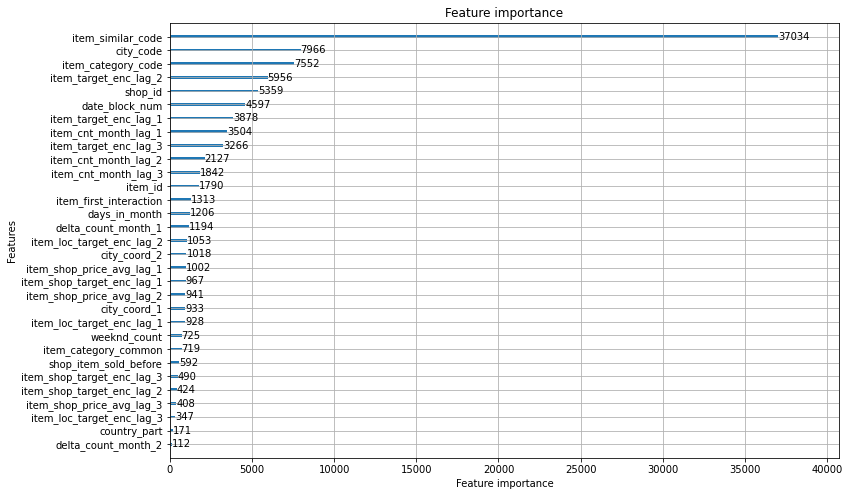

In [85]:
lgb.plot_importance(
    gbm, 
    max_num_features=50, 
    importance_type='split', 
    figsize=(12,8));

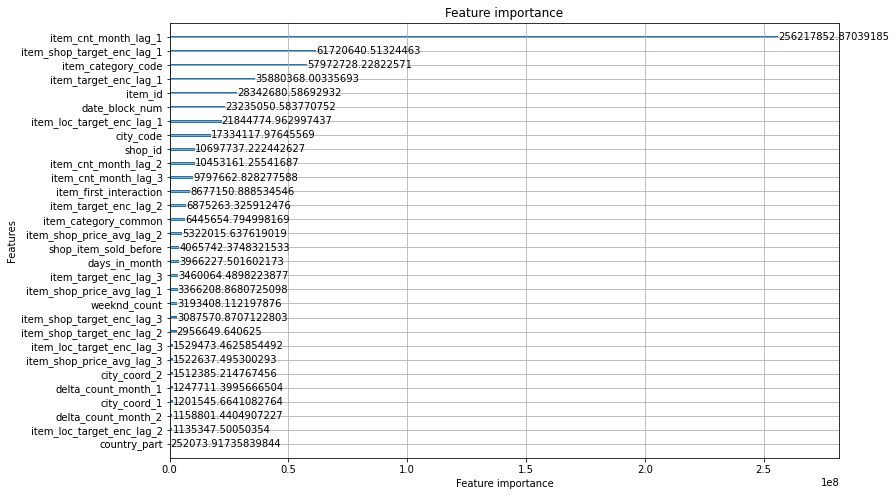

In [71]:
lgb.plot_importance(
    gbm, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8));

In [ ]:
lgb.plot_importance(
    gbm, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8));

In [ ]:
#items_subset = items[['item_id', 'item_name']]
#feature_count = 35
#tfidf = TfidfVectorizer(max_features=feature_count)
#items_df_item_name_text_features = pd.DataFrame(tfidf.fit_transform(items_subset['item_name']).toarray())

#cols = items_df_item_name_text_features.columns
#for i in range(feature_count):
#    feature_name = 'item_name_tfidf_' + str(i)
#    items_subset[feature_name] = items_df_item_name_text_features[cols[i]]

#items_subset.drop('item_name', axis = 1, inplace = True)